## Welcome to the Tensorflow Mobilenet transfer learning workshop!
### Here we are going to learn how to take a pretrained Mobilenet V2 from Keras and use transfer learning to apply it to a new dataset.

In [ ]:
!pip install tqdm
!pip install sagemaker-experiments

In [41]:
%pylab inline
import boto3, re, os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlow
from smexperiments.experiment import Experiment
from smexperiments.tracker import Tracker
from smexperiments.trial import Trial
import tarfile
import tensorflow as tf
from glob import glob
import numpy as np
import subprocess
from tqdm import tqdm
import cv2
import json

role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()
sage = boto3.client('sagemaker')
runtime_client = boto3.client('runtime.sagemaker')

Populating the interactive namespace from numpy and matplotlib


Let's first download the data, we are going to be working with the Caltech256 dataset

In [ ]:
!wget https://caltech256-bucket.s3.amazonaws.com/256_ObjectCategories.tar .
!tar -xvf 256_ObjectCategories.tar 
!rm -rf 256_ObjectCategories.tar 

Unfortunately, if we want to use multiple GPUs in Keras, currently we cannot simply access images from a directory, we instead need our images to be in the format of a Numpy array. 

In [6]:
categories = {}
folders = os.listdir('256_ObjectCategories/')
folders.sort()
for d in folders:
    files = glob(f'256_ObjectCategories/{d}/*.jpg')
    files.sort()
    categories[d] = files
    
# since there are not the same amount of images for each category we are going to want to even them out.
ls = []
for cat in categories:
    l = len(categories[cat])
    ls.append(l)
    
examples = min(ls)
ex_ind = np.argmin(ls)
print(f'Minimum number of examples is {examples}')

Minimum number of examples is 80


We will load our images using OpenCV, these specific images are in RGB format, so in order to 

In [9]:
imgs = []
labs = []

for j,cat in tqdm(enumerate(list(categories.keys())[:20])):
    for i,file in enumerate(categories[cat]):
        img = cv2.imread(file)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(np.array(img))
        labs.append(j)

img_arr = np.array(imgs) # , dtype=np.float32
labels = tf.keras.utils.to_categorical(labs)
del imgs, labs

20it [00:04,  4.42it/s]


Let's take a look at one of the images

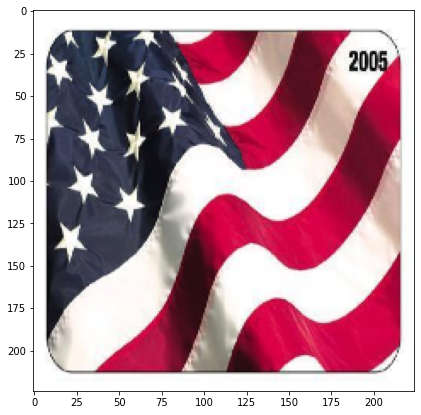

In [10]:
plt.figure(figsize=(14,7))
plt.imshow(img_arr[98])

Let's split our data into train and test sets

In [11]:
split = .8
inds = np.arange(img_arr.shape[0])
np.random.shuffle(inds)
train_x = img_arr[:(int(inds.shape[0]*split))]
train_y = labels[:(int(inds.shape[0]*split))]
test_x = img_arr[(int(inds.shape[0]*split)):]
test_y = labels[(int(inds.shape[0]*split)):]

Now we need to save our data and move it to s3 so that your model can access it.

In [17]:
os.makedirs('data', exist_ok=True)

np.save('data/train_data.npy',train_x)
np.save('data/train_labels.npy',train_y)
np.save('data/eval_data.npy',test_x)
np.save('data/eval_labels.npy',test_y)


For simplicity we can just download the data from this s3 bucket:

In [18]:
!aws s3 cp --recursive data s3://{bucket}/caltech256

upload: data/eval_labels.npy to s3://sagemaker-us-east-1-209419068016/caltech256/eval_labels.npy
upload: data/train_labels.npy to s3://sagemaker-us-east-1-209419068016/caltech256/train_labels.npy
upload: data/eval_data.npy to s3://sagemaker-us-east-1-209419068016/caltech256/eval_data.npy
upload: data/train_data.npy to s3://sagemaker-us-east-1-209419068016/caltech256/train_data.npy


In [20]:
training_data_uri = f's3://{bucket}/caltech256/'
output_uri = f's3://{bucket}/mobilenet/'

mobile_experiment = Experiment.create(
    experiment_name="mobilenet-tf-caltech256-classification-ex", 
    description="Finetune mobilenet on caltech256", 
    sagemaker_boto_client=sage)

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sage) as tracker:
     tracker.log_input(name="caltech-dataset", media_type="s3/uri", value=training_data_uri)

## Look at model we are training

In [50]:
target_shape=20
base_learning_rate = .001
base_model = tf.keras.applications.ResNet50(input_shape=None, include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000) # mobilenet_v2.MobileNetV2
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#addl_dense = tf.keras.layers.Dense(256,activation='relu')
prediction_layer = tf.keras.layers.Dense(target_shape, activation='softmax')
model = tf.keras.Sequential([
              base_model,
                      global_average_layer,
              #addl_dense,
              prediction_layer
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


## Get non-finetuned predictions

In [52]:
file = '002_0096.jpg'
img = cv2.imread(file)
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.reshape(img,(1,224,224,3))
out = model.predict(img)

out

array([[0.05580279, 0.04134727, 0.01698174, 0.01283453, 0.03802286,
        0.0077511 , 0.02631607, 0.00641993, 0.00590071, 0.07075395,
        0.02436975, 0.05262715, 0.13769883, 0.01761459, 0.06074368,
        0.02632174, 0.00556344, 0.21018638, 0.05610369, 0.12663975]],
      dtype=float32)

Here we specify our estimator and training script that will get executed on a training instance. We can specify the type of instances and number of instances to run training on when we specify our estimator. Let's take a look at mobile_keras.py.

In [54]:
hyperparameters1 = {'epochs':20, 'lr':.0001, 'batch_size':512, 'target_shape':20}
hyperparameters2 = {'epochs':20, 'lr':.005, 'batch_size':512, 'target_shape':20}

for i, params in enumerate([hyperparameters1, hyperparameters2]):
    trial_name = f"cnn-training-job-params{i}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mobile_experiment.experiment_name,
        sagemaker_boto_client=sage,
    )
    cnn_trial.add_trial_component(tracker.trial_component)
    mobile_estimator = TensorFlow(
                          entry_point=f'mobile-keras.py', # this points to the script that will execute training
                          model_dir=output_uri, # where the model will eventually be saved
                         role=role,
                         train_instance_count=1, 
                         train_instance_type='ml.p3.8xlarge',
                         framework_version='2.1',
                         py_version='py3',
                        hyperparameters=params,
                          script_mode=True,
                         distributions={'parameter_server': {'enabled': True}},
                        metric_definitions=[
                             {'Name':'train:accuracy', 'Regex':'accuracy: [0-9].[0-9][0-9][0-9][0-9]'},
                             {'Name':'train:loss', 'Regex':'loss: [0-9].[0-9][0-9][0-9][0-9]'},
#                             {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
                        ],
    ) #,
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    mobile_estimator.fit(
        inputs={'training': training_data_uri}, 
        job_name=cnn_training_job_name,
        logs=True,
        experiment_config={
            "ExperimentName": mobile_experiment.experiment_name, 
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        }
    )


INFO:sagemaker:Amazon SageMaker Debugger does not currently support Parameter Server distribution
INFO:sagemaker:Creating training-job with name: cnn-training-job-1597321228


2020-08-13 12:20:28 Starting - Starting the training job...
2020-08-13 12:20:31 Starting - Launching requested ML instances......
2020-08-13 12:21:46 Starting - Preparing the instances for training......
2020-08-13 12:22:58 Downloading - Downloading input data......
2020-08-13 12:23:40 Training - Downloading the training image...
2020-08-13 12:24:25 Training - Training image download completed. Training in progress..2020-08-13 12:24:30,048 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-08-13 12:24:37,889 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_parameter_server_enabled": true
    },
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 51

UnexpectedStatusException: Error for Training job cnn-training-job-1597321228: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/bin/python3 mobile-keras.py --batch_size 512 --epochs 20 --lr 0.0001 --model_dir s3://sagemaker-us-east-1-209419068016/mobilenet/ --target_shape 20"

In [24]:
from sagemaker.analytics import ExperimentAnalytics
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sess, 
    experiment_name=mobile_experiment.experiment_name
)
analytic_table = trial_component_analytics.dataframe()

In [25]:
analytic_table

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,batch_size,epochs,lr,...,sagemaker_program,sagemaker_region,sagemaker_submit_directory,target_shape,training - MediaType,training - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,caltech-dataset - MediaType,caltech-dataset - Value
0,cnn-training-job-1597290752-aws-training-job,Training,arn:aws:sagemaker:us-east-1:209419068016:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/t...,1.0,ml.p3.8xlarge,30.0,512.0,20.0,0.0050,...,"""mobile-keras.py""","""us-east-1""","""s3://sagemaker-us-east-1-209419068016/cnn-tra...",20.0,NaN,s3://sagemaker-us-east-1-209419068016/caltech256/,NaN,s3://sagemaker-us-east-1-209419068016/cnn-trai...,NaN,NaN
1,cnn-training-job-1597290379-aws-training-job,Training,arn:aws:sagemaker:us-east-1:209419068016:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/t...,1.0,ml.p3.8xlarge,30.0,512.0,20.0,0.0001,...,"""mobile-keras.py""","""us-east-1""","""s3://sagemaker-us-east-1-209419068016/cnn-tra...",20.0,NaN,s3://sagemaker-us-east-1-209419068016/caltech256/,NaN,s3://sagemaker-us-east-1-209419068016/cnn-trai...,NaN,NaN
2,cnn-training-job-1597290029-aws-training-job,Training,arn:aws:sagemaker:us-east-1:209419068016:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/t...,1.0,ml.p3.8xlarge,30.0,512.0,4.0,0.0050,...,"""mobile-keras.py""","""us-east-1""","""s3://sagemaker-us-east-1-209419068016/cnn-tra...",20.0,NaN,s3://sagemaker-us-east-1-209419068016/caltech256/,NaN,s3://sagemaker-us-east-1-209419068016/cnn-trai...,NaN,NaN
3,cnn-training-job-1597289625-aws-training-job,Training,arn:aws:sagemaker:us-east-1:209419068016:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/t...,1.0,ml.p3.8xlarge,30.0,512.0,4.0,0.0001,...,"""mobile-keras.py""","""us-east-1""","""s3://sagemaker-us-east-1-209419068016/cnn-tra...",20.0,NaN,s3://sagemaker-us-east-1-209419068016/caltech256/,NaN,s3://sagemaker-us-east-1-209419068016/cnn-trai...,NaN,NaN
4,cnn-training-job-1597289399-aws-training-job,Training,arn:aws:sagemaker:us-east-1:209419068016:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/t...,1.0,ml.p3.8xlarge,30.0,512.0,4.0,0.0001,...,"""mobile-keras.py""","""us-east-1""","""s3://sagemaker-us-east-1-209419068016/cnn-tra...",NaN,NaN,s3://sagemaker-us-east-1-209419068016/caltech256/,NaN,s3://sagemaker-us-east-1-209419068016/cnn-trai...,NaN,NaN
5,TrialComponent-2020-08-13-032949-hgev,Preprocessing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,s3/uri,s3://sagemaker-us-east-1-209419068016/caltech256/


Now that we have a trained model, let's deploy our endpoint! We can do so easily by using the deploy command:

In [27]:
mobile_end = mobile_estimator.deploy(initial_instance_count=1, instance_type='ml.g4dn.12xlarge',
                                     endpoint_name='mobile-endpoint-tfserve',
                                    endpoint_type='tensorflow-serving',
                                    )

INFO:sagemaker:Creating model with name: cnn-training-job-1597290752
INFO:sagemaker:Creating endpoint with name mobile-endpoint-tfserve


---------------!

Let's download an image for testing

In [26]:
!wget https://caltech256-bucket.s3.amazonaws.com/002_0096.jpg  

--2020-08-13 04:19:35--  https://caltech256-bucket.s3.amazonaws.com/002_0096.jpg
Resolving caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)... 52.216.84.235
Connecting to caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)|52.216.84.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11062 (11K) [image/jpeg]
Saving to: ‘002_0096.jpg’

002_0096.jpg        100%[===================>]  10.80K  --.-KB/s    in 0s      

2020-08-13 04:19:35 (202 MB/s) - ‘002_0096.jpg’ saved [11062/11062]



If you have deployed your endpoint from training, you can simply call the endpoint to make a prediction. The endpoint class will handle the serialization. If you want to invoke an endpoint you created previously you can use the runtime client to invoke the endpoint 

In [32]:
# if you don't have the sagemaker runtime client initialized call:
#runtime_client = boto3.client('runtime.sagemaker')

In [33]:

file = '002_0096.jpg'
img = cv2.imread(file)
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.reshape(img,(1,224,224,3))

# calling an endpoint for a model you trained in the same notebook 
#response = mobile_end.predict(img)

# this will call an endpoint you have previously deployed 
response = runtime_client.invoke_endpoint(EndpointName='mobile-endpoint-tfserve',#endpoint_name,
                                       ContentType='application/json',
                                       Body=json.dumps(img.tolist()))
response = eval(response['Body'].read().decode('utf-8'))

response

{'predictions': [[4.86196361e-10,
   2.12627624e-10,
   0.00172962935,
   0.125879183,
   1.13390257e-08,
   3.5126374e-10,
   2.97320391e-10,
   0.0722157806,
   1.7646304e-08,
   8.20928303e-09,
   0.00753454259,
   0.00028161658,
   6.35206092e-08,
   4.8869081e-10,
   0.792359173,
   1.24172533e-10,
   1.59910918e-10,
   1.52416149e-10,
   4.646101e-10,
   7.63320185e-10]]}

In [40]:
%%time 
response = mobile_end.predict(img)

CPU times: user 36.7 ms, sys: 335 µs, total: 37 ms
Wall time: 79.5 ms


We can find the code for the container here: https://github.com/aws/sagemaker-tensorflow-serving-container

To deploy an endpoint for a model you trained in a different session it's very simple:

In [44]:
from sagemaker.tensorflow.serving import Model

region = boto3.Session().region_name
#saved_model = sagemaker.session.Session().upload_data('model.tar.gz')

tensorflow_model = Model(model_data='s3://sagemaker-us-east-1-209419068016/cnn-training-job-1588780346/output/model.tar.gz',
                         role=role,
                         framework_version='1.14')

In [45]:
%%time
predictor = tensorflow_model.deploy(initial_instance_count=1,
                                    instance_type='ml.p3.2xlarge', endpoint_name='mobile-endpoint-pretrained')

INFO:sagemaker:Creating model with name: tensorflow-inference-2020-05-07-13-45-22-638
INFO:sagemaker:Creating endpoint with name mobile-endpoint-pretrained


---------------!CPU times: user 246 ms, sys: 17.2 ms, total: 263 ms
Wall time: 7min 32s


In [ ]:
file = 'Postmen_Office_Room.jpg'
img = cv2.imread(file)
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.reshape(img,(1,224,224,3))
response = predictor.predict(img)

response = runtime_client.invoke_endpoint(EndpointName='mobile-endpoint',#endpoint_name,
                                       ContentType='application/json',
                                       Body=json.dumps(img.tolist()))
response = eval(response['Body'].read().decode('utf-8'))

np.argmax(response['predictions'])

In [ ]:
%%time 
response = predictor.predict(img)